In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import h5py

In [2]:
from dtfe.impl3d import tetrahedron_volume, compute_gradient_scalar, compute_gradient_vector, compute_densities
from dtfe.dtfe import map_affine

In [3]:
from scipy.spatial import Delaunay
class DTFE:
    def __init__(self, points, velocities, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        #The gradient
        print("\t-Evaluate velocity gradient")
        self.Dv = compute_gradient_vector(self.delaunay.points, self.delaunay.simplices, self.velocities)

    # interpolation

    def theta(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return (self.Dv[simplexIndex][...,0,0] + 
                self.Dv[simplexIndex][...,1,1] + 
                self.Dv[simplexIndex][...,2,2])


# Uchuu

In [4]:
from src import load_bgs

/global/homes/a/agillesl/.conda/envs/lemaitre/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
2025-01-09 08:34:14,232 INFO sparse_dot_mkl found. Building hessian should be faster.
2025-01-09 08:34:14,260 INFO loading lemaitre filterlib from /global/homes/a/agillesl/.cache/bbf/lemaitre_flib.default.0b8479e36fca60c99e76ea84d98cbe0c7383608814cddfaef21626fdf668b5c5.pkl
2025-01-09 08:34:15,558 INFO Unable to initialize backend 'cuda': 
2025-01-09 08:34:15,560 INFO Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-01-09 08:34:15,564 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-01-09 08:34:15,565 WARNING An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
bgs_df = load_bgs(filename='Uchuu_0.2.csv', columns=['RA', 'DEC', 'Z_COSMO', 'Z', 'HALO_ID', 'PID', 'STATUS'], in_desi=False)

In [4]:
# to_use=[]
# used_halos = set(bgs_df.halo_id)
# for i in tqdm(range(100)):
#     with h5py.File(file_dir+f'halolist_z0p00_{i}.h5', 'r') as file:
#         # print("Keys: %s"% file.keys())
#         snapshot_id = set(np.int64(file["id"]))
#     if used_halos.intersection(set(snapshot_id)):
#         to_use.append(i)

In [4]:
to_use = np.arange(50)

In [4]:
file_dir="/global/cfs/cdirs/desi/mocks/cai/Uchuu-SHAM/Uchuu-halo-catalogs/halodir_050/"

In [5]:
with h5py.File(file_dir+f'halolist_z0p00_0.h5', 'r') as file:
    filt = np.array(file["M200c"]) > 1e11
    positions = np.array([file["x"][filt], file["y"][filt], file["z"][filt]]).T
    velocities = np.array([file["vx"][filt], file["vy"][filt], file["vz"][filt]]).T
    masses = np.array(file["M200c"][filt])
    del filt


In [6]:
positions.shape

(2658469, 3)

In [7]:
%%time
dtfe = DTFE(positions[:10], velocities[:10], masses[:10])

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate velocity gradient
CPU times: user 5.72 s, sys: 130 ms, total: 5.85 s
Wall time: 5.96 s


Text(0, 0.5, 'Count')

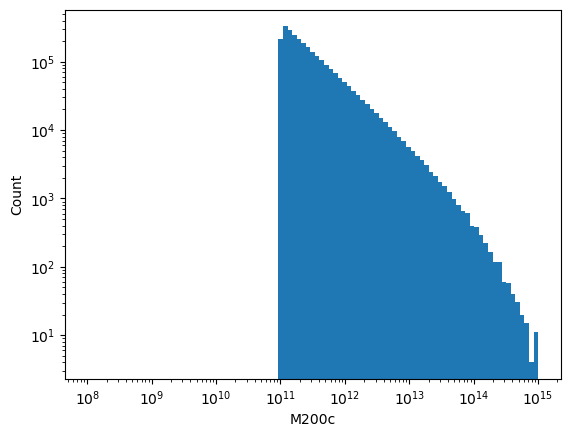

In [8]:
_=plt.hist(masses, bins=np.logspace(8, 15, 100), cumulative=False, log=True, density=False)
plt.semilogx()
plt.xlabel("M200c")
plt.ylabel("Count")

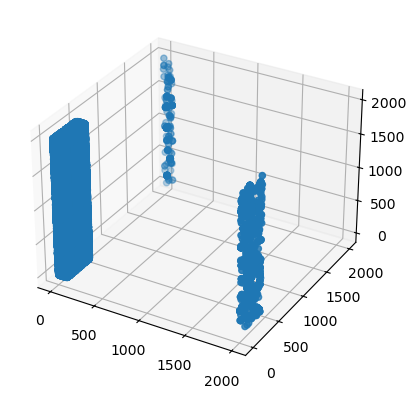

In [87]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(*positions.T)

In [9]:
filt = np.all(positions < 200, axis=1)

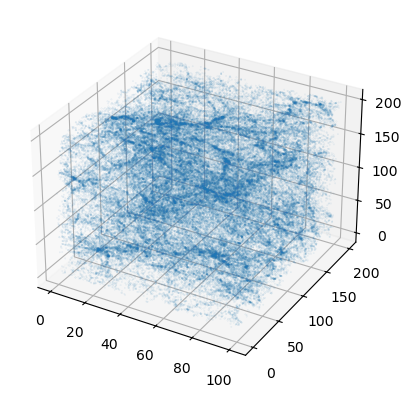

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(*positions[filt].T, s=0.1, marker=".", alpha=0.2)

In [21]:
%%time
dtfe = DTFE(positions, velocities, masses)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate velocity gradient
CPU times: user 2min 32s, sys: 3.81 s, total: 2min 36s
Wall time: 2min 37s


In [30]:
n=1024
yy, zz = np.meshgrid(np.linspace(0,2000,n), np.linspace(0,2000,n))
xx = 10*np.ones(n**2)

In [31]:
from matplotlib.colors import SymLogNorm

In [32]:
theta=dtfe.theta(xx.ravel(), yy.ravel(), zz.ravel()).reshape(n,n)

In [33]:
slice_x = np.abs(positions[:,0] - 10) < 1

(0.0, 400.0)

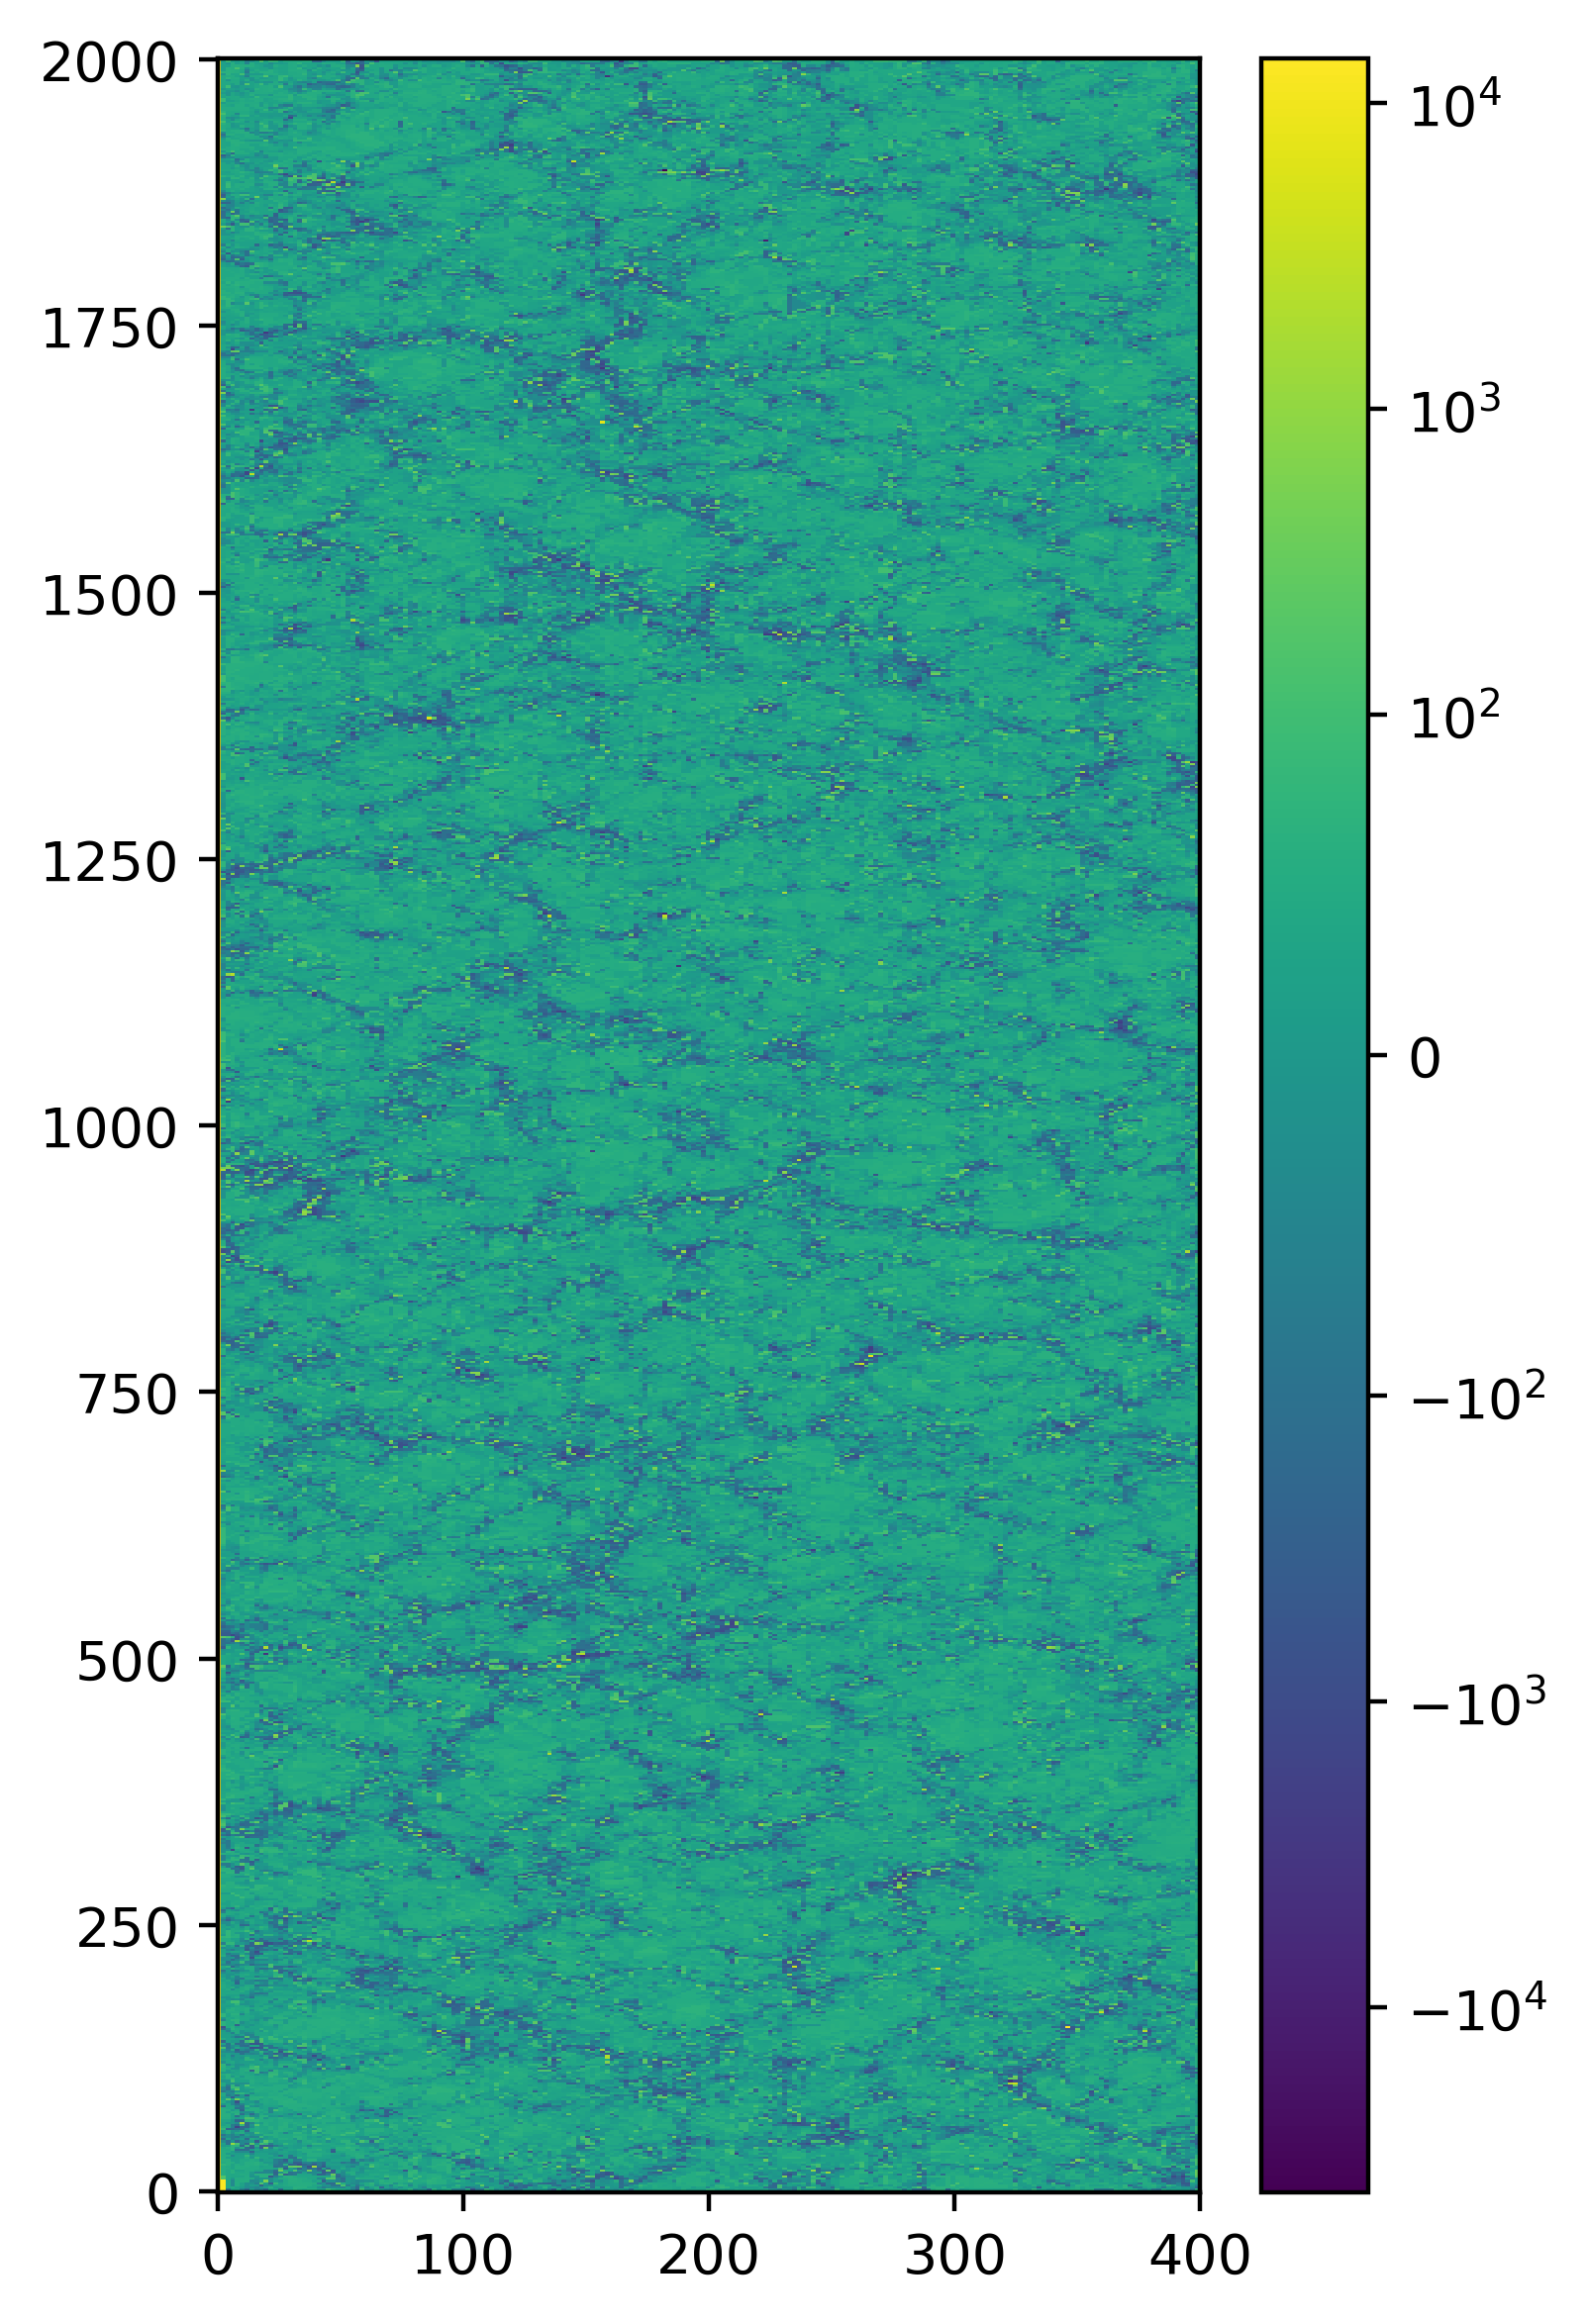

In [35]:
plt.figure(figsize=(4,7), dpi=400)
plt.pcolormesh(yy, zz, theta, shading='auto', norm=SymLogNorm(linthresh=100))
plt.colorbar()
# plt.scatter(*positions[slice_x][:,1:].T, s=0.1, color='r', marker=".", alpha=0.5)
plt.xlim(0, 400)

In [36]:
from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging

# To activate logging
setup_logging()

In [39]:
thetas = dtfe.theta(*positions.T)

In [41]:
kedges = np.linspace(0, 0.2, 11)
ells = 0
mesh1 = CatalogMesh(data_positions=positions, data_weights=thetas,
                    interlacing=2, boxsize=None, nmesh=128, resampler='tsc', position_type='xyz', mpiroot=0)

ValueError: For position type = xyz, please provide a list of 3 arrays for positions (found 2658469)

In [13]:
halos=[]
for snap in tqdm(to_use):
    with h5py.File(file_dir+f'halolist_z0p00_{snap}.h5', 'r') as file:
        filt = np.array(file["M200c"]) > 1e11
        df = pandas.DataFrame({k:file[k][filt] for k in ["x", "y", "z", "vx", "vy", "vz", "M200c"]})
        del filt
    halos.append(df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
halos = pandas.concat(halos)

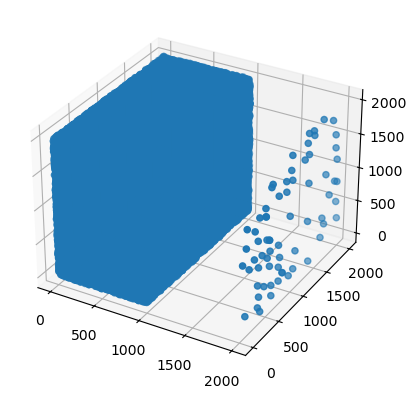

In [15]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(halos['x'][::100], halos['y'][::100], halos['z'][::100])

In [ ]:
dtfe = DTFE(np.array(halos[['x','y','z']]), np.array(halos[['vx','vy','vz']]), np.array(halos['M200c']))

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation


In [24]:
halos['vpec']=((halos.x - 1000)*halos.vx + (halos.y - 1000)*halos.vy + (halos.z - 1000)*halos.vz)/\
                np.sqrt((halos.x - 1000)**2 + (halos.y - 1000)**2 + (halos.z - 1000)**2)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(projection="3d")
                      )
ax.scatter(halos[::100000].x, halos[::100000].y, halos[::100000].z, marker=".", s=.05, alpha=0.1)

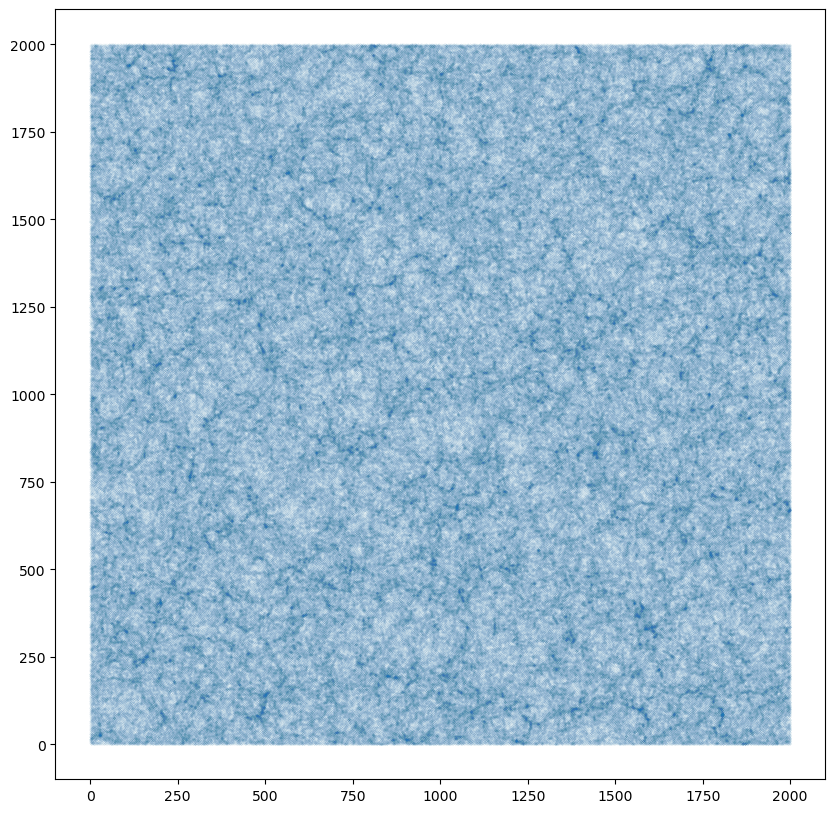

In [12]:
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(aspect="equal")
                      )
ax.scatter(halos[::100].z, halos[::100].y, marker=".", s=.05, alpha=0.1)


# Abacus

In [1]:
from abacusnbody.data.read_abacus import read_asdf

In [2]:
pid_file="/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_base_c000_ph000/halos/z0.100/halo_pid_A/halo_pid_A_000.asdf"

In [3]:
file="/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_base_c000_ph000/halos/z0.100/halo_rv_A/halo_rv_A_000.asdf"
data = read_asdf(file)

In [2]:
import numpy as np

In [3]:
import glob

In [4]:
files = glob.glob("/global/cfs/cdirs/desi/cosmosim/Abacus/AbacusSummit_base_c000_ph000/halos/z0.100/halo_rv_A/*.asdf")

In [5]:
all_pos = np.vstack([read_asdf(filename)["pos"].data for filename in files])

In [6]:
from MAS_library import MA

In [7]:
# density field parameters
grid    = 256    #the 3D field will have grid x grid x grid voxels
BoxSize = 2000.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress

# define 3D density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)

In [8]:
all_pos.shape

(4209883445, 3)

In [9]:
MA(all_pos, delta, BoxSize, MAS, verbose=verbose)


Using CIC mass assignment scheme
Time taken = 54.005 seconds



In [10]:
delta /= np.mean(delta, dtype=np.float64)
delta -= 1

In [11]:
import matplotlib.pyplot as plt

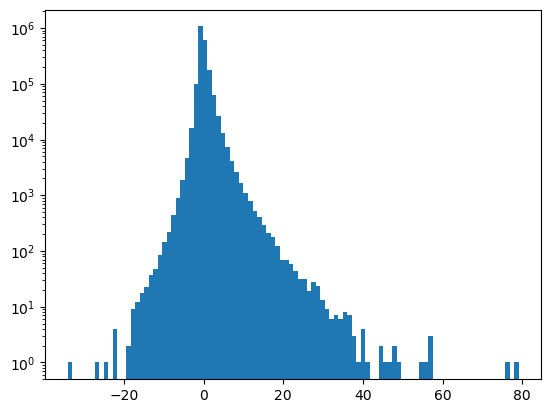

In [12]:
_=plt.hist(delta.flatten(), log=True, bins=100)

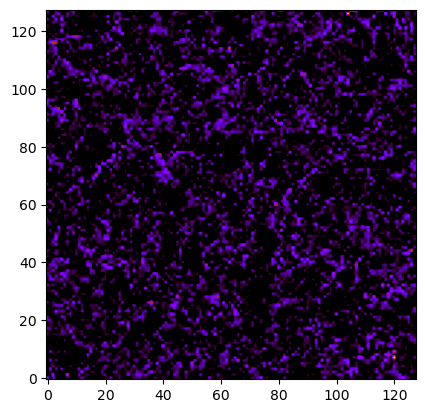

In [18]:
plt.imshow(np.mean(delta[60:70,:,:], axis=0), cmap='gnuplot', vmin=0.0, origin='lower')

In [30]:
X[delta > 0]

array([-500., -500., -500., ...,  500.,  500.,  500.])

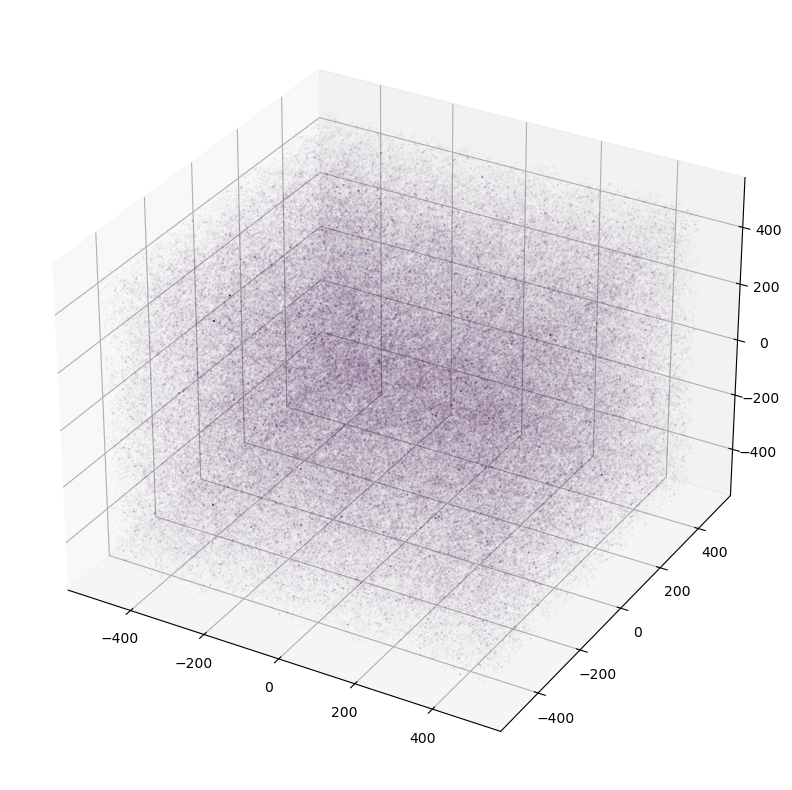

In [36]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={"projection":"3d"})
ax.scatter3D(X[delta > 0], Y[delta > 0], Z[delta > 0],
             s=1,
             marker=".",
             c=delta[delta > 0],
             cmap='viridis',
             alpha=delta[delta > 0]/delta.max())